# London Tube Map Data Preparation

## 1. Introduction

The following code is meant to output suitable data for a Power BI Dashboard containing an adjustable London Tube Map. In this notebook I gather data (station names, lines, zones, and coordinates) about london underground stations from Wikipedia using the Python requests, bs4, lxml and re libraries. I combine this with some available data on average hourly exits from each station.

## 2. Web-Scraping

In this section I create a pandas data frame containing station name, line(s), zone(s), and coordinate data. First, necessary libraries are imported before scraping the "List_of_London_Underground_stations" Wikipedia article. The data are organized in a pandas dataframe to be ideal for later working in Power BI. See comments in code for more details on the steps completed.

In [1]:
#Import Libraries
import requests
import bs4
import lxml
import re

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Connect to the table containing stations names, links to individual pages, lines, and zones
res = requests.get("https://en.wikipedia.org/wiki/List_of_London_Underground_stations")
soup = bs4.BeautifulSoup(res.text, "lxml")

table = soup.find('table')
tbody = table.find('tbody')
rows = tbody.findAll('tr')

In [2]:
#Check that the connection is producing the desired result
rows[1].find('th').find('a').get('title')

'Acton Town tube station'

In [3]:
#Create lists of station names and coordinates
station_names = []
latitude = []
longitude = []

for row in rows[1:]:
    #Get and prepare all station names and append to list
    station = row.find('th').find('a')
    title = station.get('title')
    title = title.replace(' tube station', '')
    title = title.replace(' station', '')
    title = title.replace(' stations', '')
    station_names.append(title)
    
    #Visit link to each individual station page and append all latitudes and longitudes to lists
    link = station.get('href')
    res_l = requests.get('https://en.wikipedia.org' + link)
    soup_l = bs4.BeautifulSoup(res_l.text, "lxml")
    span = soup_l.find('span', {'class' : 'geo-dec'})
    coord = re.findall(r'-?\d+\.\d+\W\w', span.get_text()) #regular expression to get coordinates from geo-dec
    
    if '°W' in coord[1]: #add negative sign to stations with W longitudes
        coord[1] = '-' + coord[1]
    coord[0], coord[1] = coord[0].replace('°N', ''), coord[1].replace('°N', '') #remove all N,W,E (for Power BI)
    coord[0], coord[1] = coord[0].replace('°W', ''), coord[1].replace('°W', '')
    coord[0], coord[1] = coord[0].replace('°E', ''), coord[1].replace('°E', '')
    
    latitude.append(coord[0])
    longitude.append(coord[1])

In [4]:
#Create lists of primary lines, secondary lines, and remaining lines for each station
line_1 = []
line_2 = []
other_lines = []

for row in rows[1:]:
    a = row.findAll('td')[1].findAll('a')

    lines = []

    for l in a:
        title = l.get('title')
        if title != None:
            title = title.replace(' (London Underground)', '')
            lines.append(title)
    
    line_1.append(lines[0])
    line_2.append(lines[1] if len(lines) > 1 else 'NaN')
    other_lines.append(' ,'.join(lines[2:]) if len(lines) > 2 else 'NaN')

In [5]:
#Create lists of primary zones and secondary zones for each station
zone_1 = []
zone_2 = []

for row in rows[1:]:
    a = row.findAll('td')[3].findAll('a')

    zones = []

    for z in a:
        title = z.get('title')
        title = title.replace('Travelcard Zone ', '')
        title = title.replace('Travelcard Zones ', '')
        zones.append(title)
    
    zone_1.append(zones[0])
    zone_2.append(zones[1] if len(zones) > 1 else 'NaN')

In [6]:
#Create dataframe and view first 5 stations
station_info = pd.DataFrame({'Station':station_names, 'Line_1':line_1, 'Line_2':line_2, 'Other_Lines':other_lines, 
                             'Zone_1':zone_1, 'Zone_2':zone_2, 'Latitude':latitude, 'Longitude':longitude})
station_info.head()

,Station,Line_1,Line_2,Other_Lines,Zone_1,Zone_2,Latitude,Longitude
0,Acton Town,District line,Piccadilly line,NaN,3,NaN,51.50278,-0.28000
1,Aldgate,Metropolitan line,Circle line,NaN,1,NaN,51.514,-0.076
2,Aldgate East,Hammersmith & City line,District line,NaN,1,NaN,51.5152,-0.0722
3,Alperton,Piccadilly line,NaN,NaN,4,NaN,51.54083,-0.29972
4,Amersham,Metropolitan line,NaN,NaN,7-9,NaN,51.674,-0.607


## 3. Exit Data Import and Further Data Exploration and Preparation

In this section I first import the hourly exit data. Some of the stations are named differently or do not appear in both dataframes, so these are adjusted to match before combining the dataframes. Observing the exits data, I noticed the bimodal distribution of the data, indicating the morning and evening rush. I wanted to know which stations were significantly more busy in the morning, indicating a station to which many people are commuting for work, school, or some other reason; or, in the evening, indicating a station to which many people are returning home (or for some other reason). I consider 7:00 to 10:00 the morning rush, and 16:00 to 19:00 the evening rush. All exits in each timeframe are grouped together for each station. Stations where morning exits are more than double evening exits are labeled Morning Peak. Stations where evening exits are more than double morning exits are labeled Evening Peak. The remaining stations are labeled other. This data is exported as a csv for further analysis in Power BI.

In [7]:
#Import exits data into a dataframe
exits = pd.read_csv('hourlyExits.csv')
print(exits.head())
print(len(exits))

        Station  H05  H06   H07   H08   H09   H10  H11  H12  H13  ...  H16  \
0    Acton Town   30  208   710   812   448   231  221  259  301  ...  634   
1       Aldgate   36  301  1319  3076  3013  1037  587  554  559  ...  721   
2  Aldgate East   50  324  1192  3045  3381  1340  897  920  919  ...  935   
3      Alperton   16  101   230   372   254   149  137  152  176  ...  444   
4      Amersham    3   18    82   246    96    56   48   62   75  ...  364   

    H17   H18   H19  H20  H21  H22  H23  H00  H01  
0   917  1077   793  505  424  424  366  210   54  
1  1116  1155   566  331  260  237  171   58    0  
2  1263  1605  1127  708  560  532  457  239   26  
3   679   724   424  222  161  143  146   72    6  
4   409   692   540  287  182  154  175   99    6  

[5 rows x 22 columns]
268


In [8]:
#Make column names easier to read
exits = exits.rename(columns={'H05': '5:00', 'H06': '6:00', 'H07': '7:00', 'H08': '8:00', 'H09': '9:00', 'H10': '10:00', 'H11': '11:00',
                      'H12': '12:00', 'H13': '13:00', 'H14': '14:00', 'H15': '15:00', 'H16': '16:00', 'H17': '17:00', 
                      'H18': '18:00', 'H19': '19:00', 'H20': '20:00', 'H21': '21:00', 'H22': '22:00', 'H23': '23:00',
                      'H00': '0:00', 'H01': '1:00'})

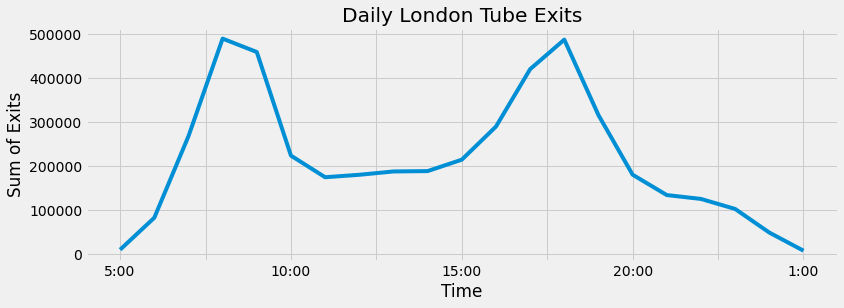

In [19]:
#Visualize total exits from London Underground by hour
exits_viz = pd.DataFrame({'Sum':exits.sum()[1:]})

plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 4))

exits_viz['Sum'].plot()
plt.ylabel('Sum of Exits')
plt.xlabel('Time')
plt.title('Daily London Tube Exits')

plt.show()

In [31]:
#Find station names that do not match between the two dataframes
station_list_1 = station_info.Station.tolist()
station_list_2 = exits.Station.tolist()

def find_differences(a, b):
    return [[x for x in a if x not in b], [a.index(x) for x in a if x not in b], [x for x in b if x not in a], [b.index(x) for x in b if x not in a]]

diff_1, index_1, diff_2, index_2 = find_differences(station_list_1, station_list_2)
print(diff_1)
print(index_1)
print(diff_2)
print(index_2)

['Bank and Monuments', 'Battersea Power Station', 'Edgware Road (Bakerloo line)', 'Edgware Road (Circle, District and Hammersmith & City lines)', 'Hammersmith (District and Piccadilly lines)', 'Hammersmith (Circle and Hammersmith & City lines)', 'Heathrow Terminals 2 & 3', 'Kew Gardens (London)', "King's Cross St Pancras", 'Bank and Monuments', 'Nine Elms', 'Paddington (Bakerloo, Circle and District lines)', 'Paddington (Circle and Hammersmith & City lines)', "Queen's Park (London)", 'Richmond (London)', "St James's Park", "St John's Wood", "St Paul's", "Shepherd's Bush", "Shepherd's Bush Market", 'London Victoria']
[11, 16, 70, 71, 95, 96, 103, 126, 130, 11, 156, 173, 174, 184, 191, 199, 200, 201, 203, 204, 243]
['Bank & Monument', 'Edgware Road (Bak)', 'Edgware Road (Cir)', 'Hammersmith (Dis)', 'Hammersmith (H&C)', 'Heathrow Terminals 123', 'Kew Gardens', "King's Cross St. Pancras", 'Paddington', "Queen's Park", 'Richmond', "Shepherd's Bush (Cen)", "Shepherd's Bush (H&C)", "St. James

In [32]:
#Change station names so that all match before concatenating the dataframes
station_list_1[11], station_list_2[11] = 'Bank and Monument', 'Bank and Monument'
station_list_2[69] = station_list_1[70]
station_list_2[70] = station_list_1[71]
station_list_2[94] = station_list_1[95]
station_list_2[95] = station_list_1[96]
station_list_2[102] = station_list_1[103]
station_list_2[125] = station_list_1[126]
station_list_2[128] = station_list_1[130]

station_list_1[174] = station_list_2[170]

station_list_2[180] = station_list_1[184]
station_list_2[187] = station_list_1[191]
station_list_2[196] = station_list_1[203]
station_list_2[197] = station_list_1[204]
station_list_2[210] = station_list_1[199]
station_list_2[211] = station_list_1[200]
station_list_2[212] = station_list_1[201]
station_list_2[239] = station_list_1[243]

diff_1, index_1, diff_2, index_2 = find_differences(station_list_1, station_list_2)
print(diff_1)
print(index_1)
print(diff_2)
print(index_2)

['Battersea Power Station', 'Bank and Monuments', 'Nine Elms', 'Paddington (Bakerloo, Circle and District lines)']
[16, 149, 156, 173]
[]
[]


In [33]:
#Merge the dataframes
station_info['Station'] = station_list_1
exits['Station'] = station_list_2

exit_data = pd.merge(station_info, exits, on='Station')
exit_data.head()

,Station,Line_1,Line_2,Other_Lines,Zone_1,Zone_2,Latitude,Longitude,5:00,6:00,...,16:00,17:00,18:00,19:00,20:00,21:00,22:00,23:00,0:00,1:00
0,Acton Town,District line,Piccadilly line,NaN,3,NaN,51.50278,-0.28000,30,208,...,634,917,1077,793,505,424,424,366,210,54
1,Aldgate,Metropolitan line,Circle line,NaN,1,NaN,51.514,-0.076,36,301,...,721,1116,1155,566,331,260,237,171,58,0
2,Aldgate East,Hammersmith & City line,District line,NaN,1,NaN,51.5152,-0.0722,50,324,...,935,1263,1605,1127,708,560,532,457,239,26
3,Alperton,Piccadilly line,NaN,NaN,4,NaN,51.54083,-0.29972,16,101,...,444,679,724,424,222,161,143,146,72,6
4,Amersham,Metropolitan line,NaN,NaN,7-9,NaN,51.674,-0.607,3,18,...,364,409,692,540,287,182,154,175,99,6


In [34]:
#Calculate daily total exits for each station
totals = exit_data.loc[:, '5:00':].sum(axis=1)
totals.head()

0     9362
1    16136
2    21206
3     5118
4     3905
dtype: int64

In [35]:
#Create peak_counts dataframe and assign AM_Peak and PM_Peak as columns
transit_map_data = exit_data.assign(AM_Peak = exit_data.loc[:, '7:00':'10:00'].apply(sum, axis=1), 
                                    PM_Peak = exit_data.loc[:, '16:00':'19:00'].apply(sum, axis=1),
                                   Total_Exits = totals)
transit_map_data.head()

,Station,Line_1,Line_2,Other_Lines,Zone_1,Zone_2,Latitude,Longitude,5:00,6:00,...,21:00,22:00,23:00,0:00,1:00,AM_Peak,PM_Peak,AM_Proportion,PM_Proportion,Total_Exits
0,Acton Town,District line,Piccadilly line,NaN,3,NaN,51.50278,-0.28000,30,208,...,424,424,366,210,54,2201,3421,0.235099,0.365413,9362
1,Aldgate,Metropolitan line,Circle line,NaN,1,NaN,51.514,-0.076,36,301,...,260,237,171,58,0,8445,3558,0.523364,0.220501,16136
2,Aldgate East,Hammersmith & City line,District line,NaN,1,NaN,51.5152,-0.0722,50,324,...,560,532,457,239,26,8958,4930,0.422428,0.232481,21206
3,Alperton,Piccadilly line,NaN,NaN,4,NaN,51.54083,-0.29972,16,101,...,161,143,146,72,6,1005,2271,0.196366,0.443728,5118
4,Amersham,Metropolitan line,NaN,NaN,7-9,NaN,51.674,-0.607,3,18,...,182,154,175,99,6,480,2005,0.122919,0.513444,3905


In [36]:
#Create a function to classify each station as 'Morning Peak', 'Evening Peak', or 'Other'
def classify_station(station):
    if station.PM_Peak > station.AM_Peak * 2:
        return 'Evening Peak'
    elif station.AM_Peak > station.PM_Peak * 2:
        return 'Morning Peak'
    else:
        return 'Other'

#Apply the function
transit_map_data = transit_map_data.assign(Peak_Travel = 
                                 transit_map_data.apply(classify_station, axis=1), axis=1)

transit_map_data.drop(transit_map_data.loc[:, '5:00':'1:00'], axis=1, inplace=True)
transit_map_data.head()

,Station,Line_1,Line_2,Other_Lines,Zone_1,Zone_2,Latitude,Longitude,AM_Peak,PM_Peak,Total_Exits,Peak_Travel
0,Acton Town,District line,Piccadilly line,NaN,3,NaN,51.50278,-0.28000,2201,3421,9362,Other
1,Aldgate,Metropolitan line,Circle line,NaN,1,NaN,51.514,-0.076,8445,3558,16136,Morning Peak
2,Aldgate East,Hammersmith & City line,District line,NaN,1,NaN,51.5152,-0.0722,8958,4930,21206,Other
3,Alperton,Piccadilly line,NaN,NaN,4,NaN,51.54083,-0.29972,1005,2271,5118,Evening Peak
4,Amersham,Metropolitan line,NaN,NaN,7-9,NaN,51.674,-0.607,480,2005,3905,Evening Peak


In [37]:
#Export final data to CSV
transit_map_data.to_csv('transit_map_data.csv', index=False)